# Practical LSTM example
### Adventures in Overfitting
### The Unreasonable Effectiveness of LSTM…at overfitting


### Use case: a custom news feed - [StreetEYE.com](http://www.streeteye.com)

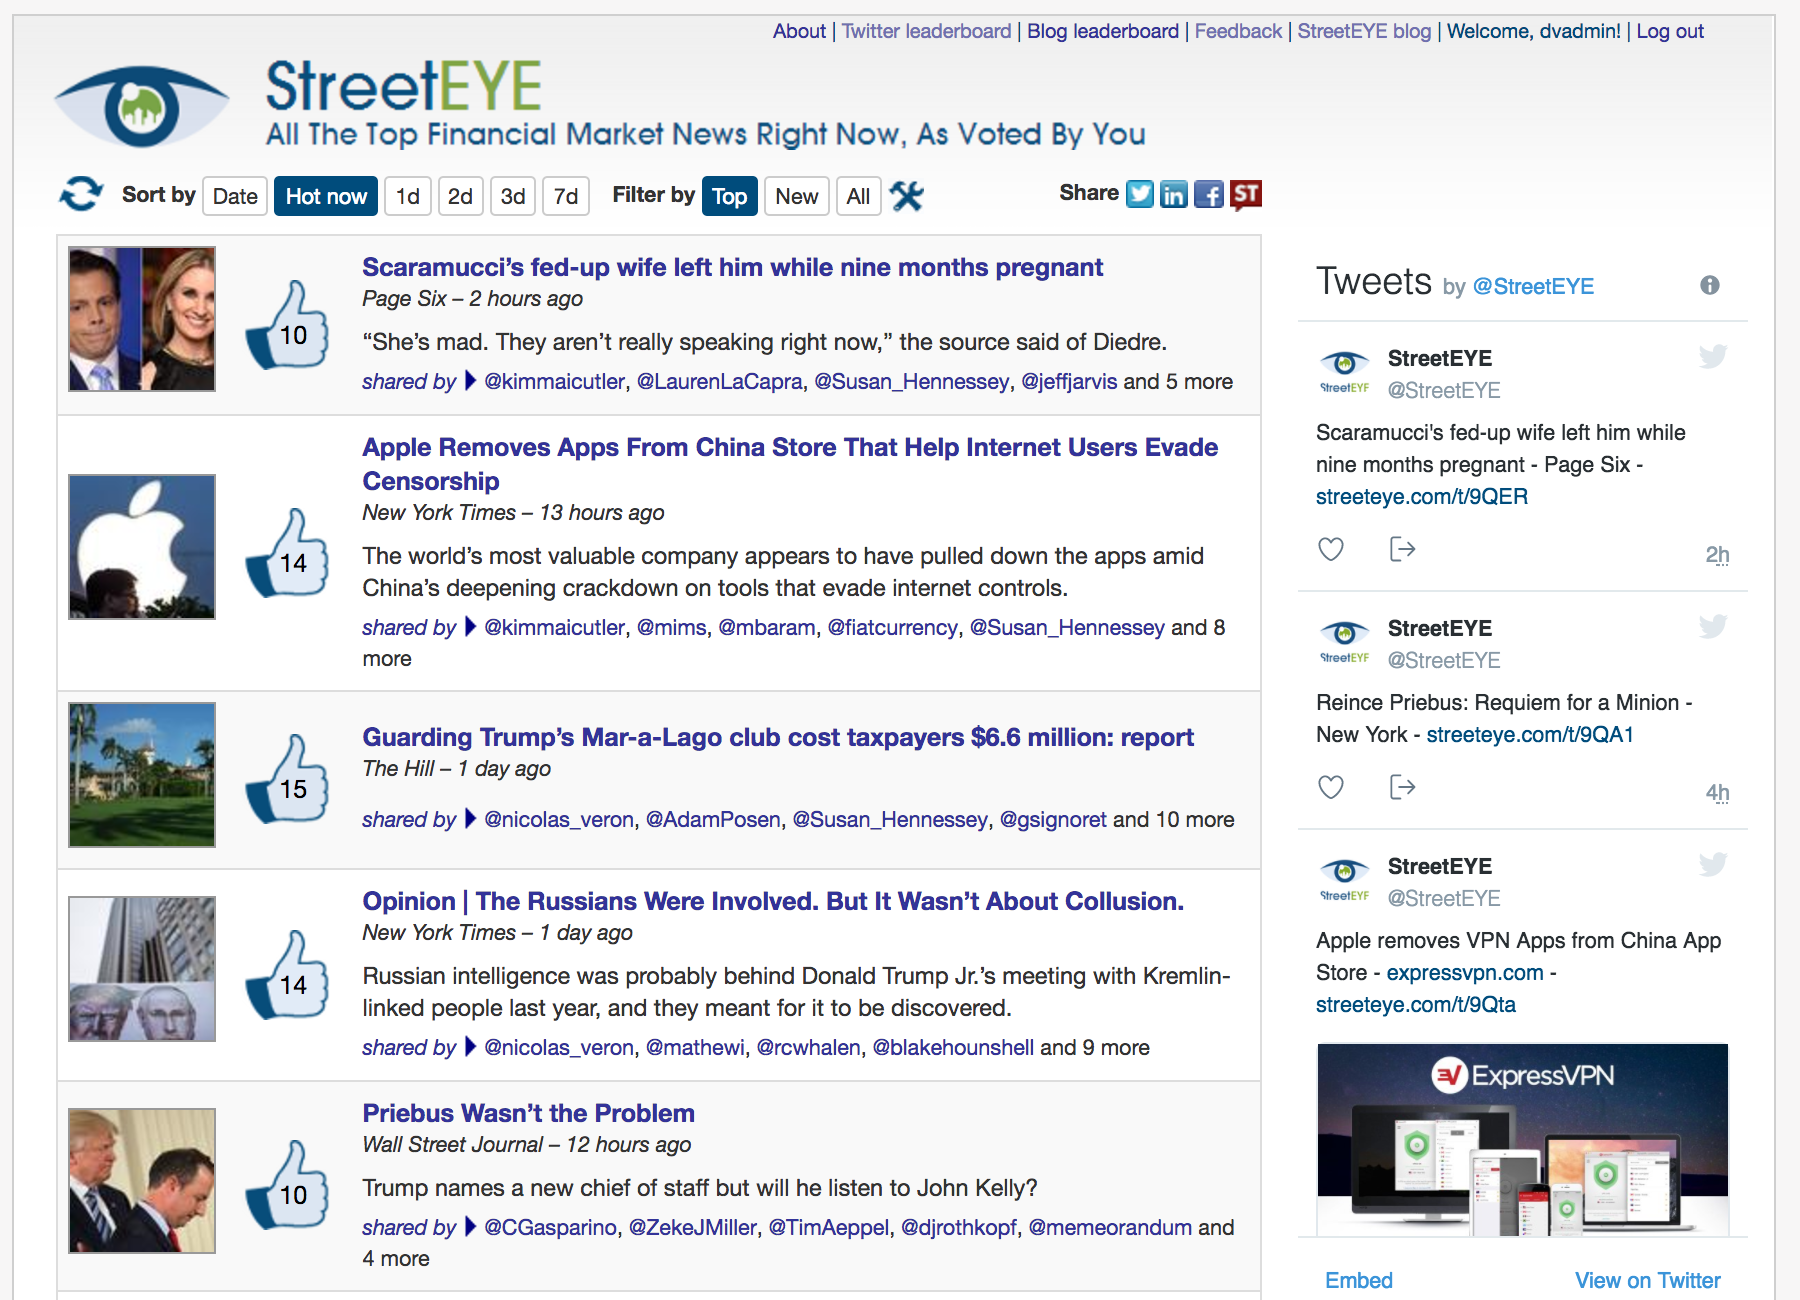

In [2]:
import os
from IPython.display import display, Image
display(Image('./se.png', width=900))

    

* Like Hacker News, other aggregation sites/apps
    * [Hacker News](https://news.ycombinator.com)
	* [Techmeme](http://www.techmeme.com/), [Memeorandum](http://www.memeorandum.com/)
	* [Nuzzel](http://nuzzel.com/)
	* Facebook trending stories (presumably a 2-way recommendation engine, simultaneously optimizes vectors describing stories and users)
	* [Flipboard](https://itunes.apple.com/us/app/flipboard-news-for-every-passion/id358801284?mt=8)/Apple News apps

* **Step 1: Follow a lot of people on social media**
    * Who are influential (high centrality)
        * For instance one can create a [social graph](http://www.streeteye.com/static/D3/forcegraph2017.html) using Twitter API
    * Who frequently share financial news stories
        * That are timely and topical
        * That tend to go viral since they are timely, topical, and shared by influential people

**Social graph force-directed**


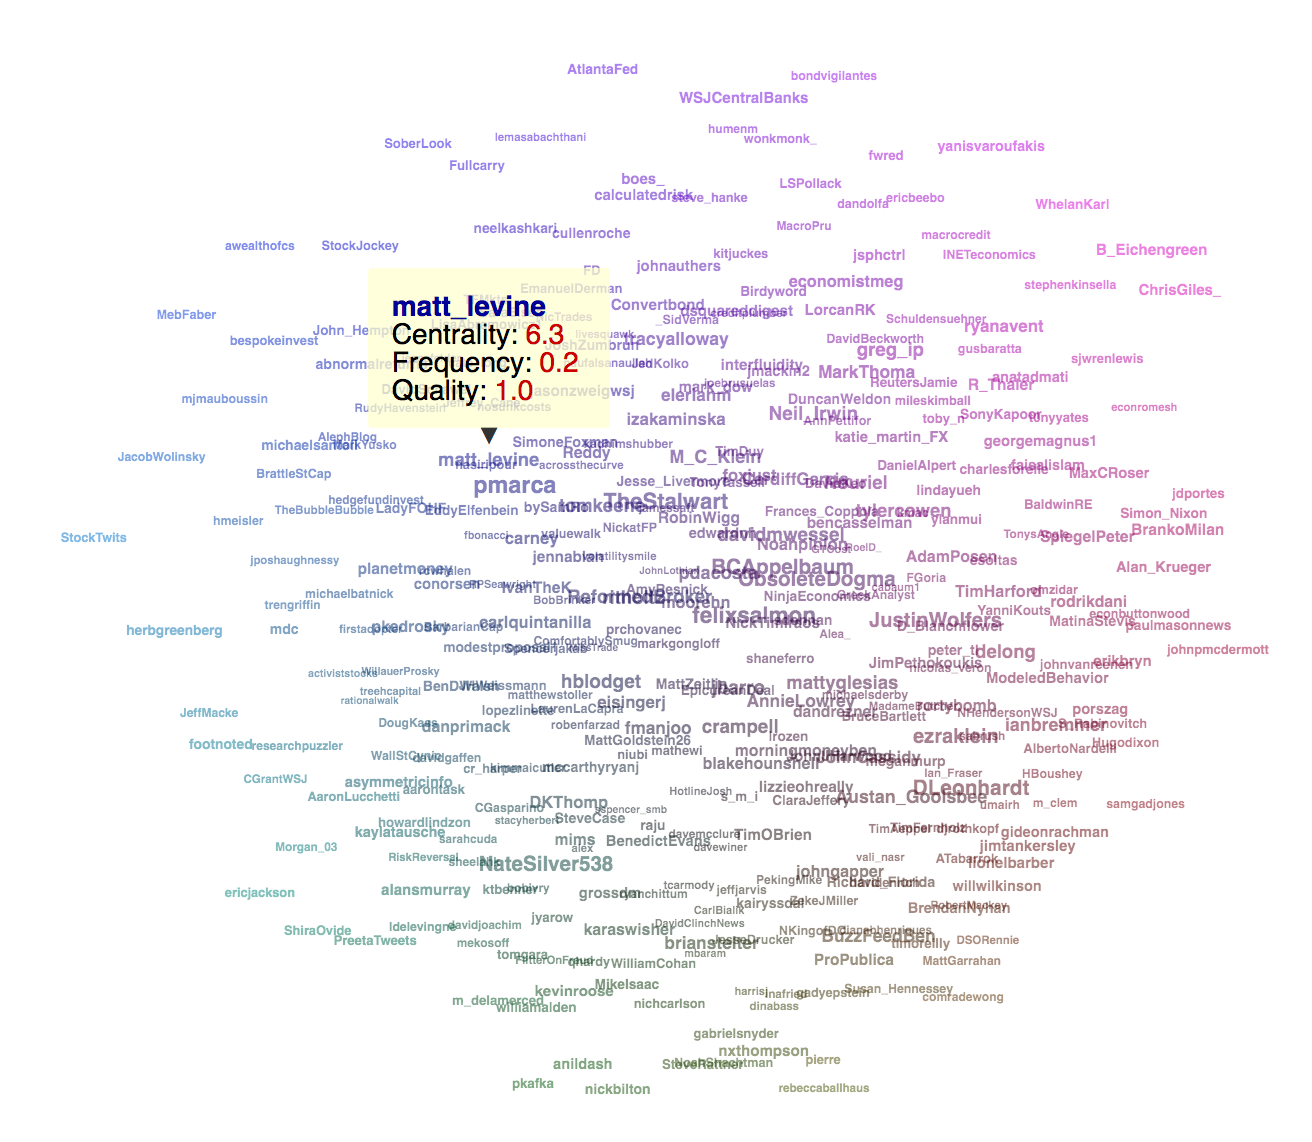

In [3]:
display(Image('./socialgraph.png', width=656))


* **Step 2: Collect data on which stories were relevant+popular**
    * Implicitly/Algorithmically by what people read
    * Explicitly upvote/tagging stories that are relevant and popular
    * Bottom line, get a big corpus of headlines, with labels

* Looks like a supervised learning problem:
    * I have a corpus that's labeled and classified
    * I want to automatically classify stories as they are discovered as probably relevant+popular, or not
    
    
* Stories labeled relevant+popular are typically
    * From a reputable source: more likely Bloomberg/FT than TMZ/Tumblr/YouTube
    * Shared by a lot of people
    * Headline words are topical, market-related (Janet Yellen, not Janet Jackson)
    

* **Step 3: Dump a data file**
    * Label - frontpage or not
    * Domain e.g. bloomberg.com: 1-hot vector of ~100 most frequent (frontpage) domains
    * Who shared it: 1-hot vector of ~1000 most frequent (frontpage) Twitter accounts, blogs, etc., e.g. 
        https://twitter.com/valuewalk
        http://thereformedbroker.com/
        * And catchall count(*) of other sharers not in top 1000
                        
    * Text of headline
        * Stem it with nltk e.g. doing, does, did -> do
            * Why? Socher says doesn't matter
            * But first attempt was a Naive Bayes/bag-of-words model with frequent/significant words
            * So already have pipeline
            * Can't hurt
            * Socher has more data/server farms than me
        * Concatenate most frequent ngrams e.g. Federal Reserve -> federal_reserve
        * Skip stopwords 'the' 'a' etc.
    * Sample very common case of headline shared by 1 or 2 folks, not popular/relevant to make classes less unbalanced


In [2]:
row = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
 0,0,0,0,0,0,0,1,
 'what go happen 2017']
len(row)

1824

* **Step 4: word2vec**
    * Why word2vec, not GloVe? Because I have working word2vec from Udemy, even though GloVe seems simpler better, couldn't find / didn't write a good GloVe implementation (is it in the Socher materials?)
    * Dump entire headline corpus (last text string) into one long document
    * Take top 10,000 words
    * Initialize using Google News pretrained corpus
    * Train further for a hour or two on my own corpus
    * Works pretty well - Look up 'jpmorgan', 'yellen' etc. using [Tensorflow embeddings projector](http://projector.tensorflow.org/?config=http://media.streeteye.com/static/D3/streeteye_embed_config.2.js)

**Step 5: Run feedforward NN, each obs is 1-hot + average embeddings**
* Label
* Giant 1-hot vector ~ 1800 columns
* As first attempt, I average all the embeddings in each headline
* Now I have ~2100 columns and a label
* Run this through neural net

In [ ]:
# function to generate model

def create_model(nn_size=30, nn_reg_penalty=0.0, nn_dropout=(1.0/3.0)):
    # create model
    model = Sequential()
    
    model.add(Dense(nn_size, 
                    activation='relu',
                    kernel_initializer='TruncatedNormal', 
                    kernel_regularizer=l1(nn_reg_penalty),
                    input_shape=(NUM_FEATURES,)
                   ))
    
    model.add(Dropout(nn_dropout))

    model.add(Dense(1, 
                    activation='sigmoid',
                    kernel_initializer='TruncatedNormal', 
                    kernel_regularizer=l1(nn_reg_penalty)
                   ))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f_score])
    print(model.summary())
    return model


* 1 hidden layer, relu activation
* Hyperparameters
    * NN size
    * L1 regularization penalty
    * Dropout
* Do a grid search


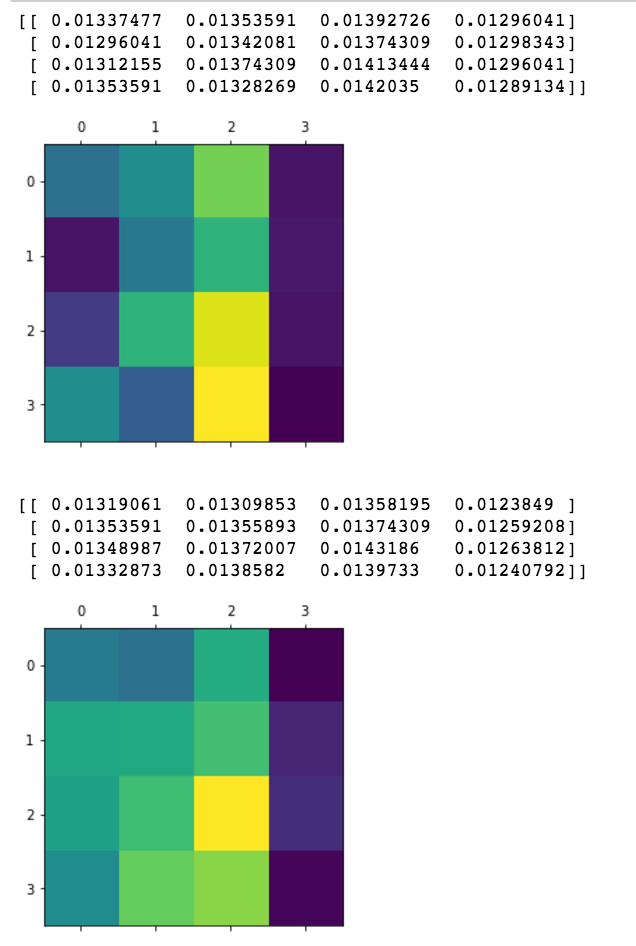

In [11]:
display(Image('./grid.png', width=368))


In [ ]:
Pretty good result
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense_129 (Dense)            (None, 64)                135872    
_________________________________________________________________
dropout_65 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_130 (Dense)            (None, 1)                 65        
=================================================================
Total params: 135,937.0
Trainable params: 135,937.0
Non-trainable params: 0.0
_________________________________________________________________
None
12:38:45 Starting
12:38:45 epoch 0 of 200
Train on 130321 samples, validate on 43440 samples
Epoch 1/1
130321/130321 [==============================] - 9s - loss: 0.5374 - acc: 0.9660 - f_score: 0.0077 - val_loss: 0.2127 - val_acc: 0.9724 - val_f_score: 0.0000e+00
...
13:05:05 epoch 199 of 200
Train on 130321 samples, validate on 43440 samples
Epoch 1/1
130321/130321 [==============================] - 7s - loss: 0.0774 - acc: 0.9852 - f_score: 0.6018 - val_loss: 0.0730 - val_acc: 0.9864 - val_f_score: 0.6486
Best Xval loss epoch 133, value 0.072672
NN units 64
Reg_penalty 0.00010000
Dropout 0.5000
Final Train Accuracy 0.988, Train F1 0.760, f_score 0.809 (beta 0.667)
[[126403   1266]
 [   253   2399]]
Final Xval Accuracy 0.987, Xval F1 0.725, f_score 0.767 (beta 0.667)
[[42100   438]
 [  140   762]]
Raw score 2 0.01431860


Test Accuracy 0.987, Test F1 0.731
[[42132   418]
 [  136   754]]

## Motivation for LSTM
* Pretty good result but…
* Ideally would like to train end to end, not pipeline training of embeddings and NN separately in a waterfall
* Extend existing architecture with an end-to-end network?
* Embeddings -> neural network -> I need a layer that takes a headlines and averages up the embedding vectors. Maybe there's a way? I don't know
* The headline is a variable length stream, which seems like a job for LSTM

* Create a data dump that looks like this
* 1,domain_otherdomain,subsource_howardlindzon,subsource_jyarow,subsource_ReformedBroker,subsource_NickatFP,subsource_mathewi,subsource_othersubsource,subsource_LongShortTrader,subsource_DKThomp,subsource_Justin_B_Smith,source_Abnormal_Returns,what,go,happen,2017
    * label
    * domain encoded as a word token
    * sources encoded as word tokens
    * headline tokens
* Effectively turn the data file into a word sentence
* Dump all the tokens into a big file (actually much smaller than 1-hot vectors), train them with word2vec (possibly redundant step)

* Create LSTM model looks like this


```
Layer (type)                 Output Shape              Param #   
=================================================================
embedding_1 (Embedding)      (None, 120, 300)          3000300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
=================================================================
Total params: 3,220,077.0
Trainable params: 3,220,077.0
Non-trainable params: 0.0
```

In [ ]:
# function to generate model

def create_model(lstm_size=30, lstm_reg_penalty=0.0, sigmoid_dropout=(1.0/3.0), sigmoid_reg_penalty=0.0001):
    # create model
    model = Sequential()

    model.add(Embedding(len(dictionary) + 1, 
                        embedding_vector_length, 
                        weights=[embedding_matrix],
                        input_length=MAX_LENGTH,
                        trainable=True))
    
    # LSTM with lstm_size units
    model.add(LSTM(lstm_size,
                   kernel_regularizer=l1(lstm_reg_penalty)))
    model.add(Dropout(sigmoid_dropout))
    
    model.add(Dense(1, 
                    activation='sigmoid',
                    kernel_initializer='TruncatedNormal', 
                    kernel_regularizer=l1(sigmoid_reg_penalty)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

* Hyperparameters: 
    * LSTM network size
    * L1 regularization not helpful in lstm
    * Sigmoid dropout
    * Sigmoid L1 regularization

* Run it, overtrains after very few epochs (near-perfect accuracy in training, mediocre performance in xval/test)
```
Train Accuracy 0.999, Train F1 0.975, f_score 0.981 (beta 0.667)
[[127430    144]
 [    30   3447]]
LSTM units 16
LSTM reg_penalty 0.00000000
Sigmoid dropout 0.5000
Sigmoid reg_penalty 0.00003000
Xval Accuracy 0.981, Xval F1 0.627, f_score 0.670 (beta 0.667)
[[42188   590]
 [  223   683]]
 ```
* Set the embeddings trainable=False
    * Still overfits, takes a little longer, few more epochs

* Finally
    *   Run some epochs with embeddings trainable=True, pick model with minimum xval loss (2 epochs -Beyond 2 epochs xval loss starts increasing again)
    *   Freeze embeddings layer, set trainable = False, recompile, train further, pick model with minimum xval loss (2 epochs) 
    
* Pretty good result




* As an aside, there is a mixed network in keras examples 
https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models
* Feed embedding to lstm
* Take out put concatenate to metadata
* Tried this…inferior result 
* <Shrug>


Takeaways
* LSTM works
* Fits very well to training data pretty quickly
* In this case overfitting is an issue
* L1 Regularization not helpful
* Can also reduce network size but seems to worsen result
* Stop training when xval loss stops improving
* In this application feedforward NN slightly better result/much simpler faster model



Columbia class
https://www.edx.org/micromasters/columbiax-artificial-intelligence
http://www.ulaff.net/    
Kaggle competition anyone?
